### **Reapply the packages, train, validation dataset**

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt

In [3]:
# Create train_ds
data_dir = 'agri_crops/Agricultural-crops'
image_size = (224, 224)
batch_size = 10

train_ds = keras.utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="int",
    validation_split=0.2,
    subset="training",
    shuffle=True,
    color_mode="rgb",
    image_size=image_size,
    batch_size=batch_size,
    seed=42
)

#Create validation_ds
validation_ds = keras.utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="int",
    validation_split=0.2,
    subset="validation",
    shuffle=True,
    color_mode="rgb",
    image_size=image_size,
    batch_size=batch_size,
    seed=42
)

Found 759 files belonging to 30 classes.
Using 608 files for training.
Found 759 files belonging to 30 classes.
Using 151 files for validation.


2025-07-19 19:19:14.667448: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [4]:
# Define augmentation as a Sequential layer
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.15),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.1),
    layers.GaussianNoise(0.02),
], name="data_augmentation")

In [5]:
# Apply data augmentation to the training set
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img, training=True), label),
    num_parallel_calls=tf.data.AUTOTUNE
)

# Prefetch for performance
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
validation_ds = validation_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

### **Make CNN Model**

In [6]:
def make_model(input_shape, num_classes):
  inputs = keras.Input(shape = input_shape)

  # Entry block
  x = layers.Rescaling(1.0 / 255)(inputs)
  x = layers.Conv2D(128, 3, strides = 2, padding = "same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)

  previous_block_activation = x # Set aside residual

  for size in [256, 512, 728]:
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    # Project residual
    residual = layers.Conv2D(size, 1, strides=2, padding="same")(
        previous_block_activation
    )
    x = layers.add([x, residual]) # Add back residual
    previous_block_activation = x # Set aside next residual

  x = layers.SeparableConv2D(1024, 3, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dropout(0.3)(x)
  x = layers.Dense(128, activation="relu")(x)

  x = layers.Dropout(0.25)(x)

  # We specify activation=None so as to return logits
  outputs = layers.Dense(num_classes, activation="softmax")(x)
  return keras.Model(inputs, outputs)

model = make_model(input_shape=image_size + (3,), num_classes=30)

In [7]:
epochs = 20

callbacks = [
    keras.callbacks.ModelCheckpoint("model_best.keras", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)
]

model.compile(
    optimizer = keras.optimizers.Adam(3e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = [keras.metrics.SparseCategoricalAccuracy(name = "acc")],
)

history = model.fit(
    train_ds,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_ds,
)

Epoch 1/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - acc: 0.0730 - loss: 3.4850

E0000 00:00:1752970939.448501    1970 meta_optimizer.cc:967] remapper failed: INVALID_ARGUMENT: Mutation::Apply error: fanout 'StatefulPartitionedCall/functional_1_1/add_2_1/Add' exist for missing node 'StatefulPartitionedCall/functional_1_1/add_1_2/Add'.


61/61 ━━━━━━━━━━━━━━━━━━━━ 185s 3s/step - acc: 0.0732 - loss: 3.4831 - val_acc: 0.0464 - val_loss: 3.4001 - learning_rate: 3.0000e-04
Epoch 2/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 171s 3s/step - acc: 0.1454 - loss: 3.0501 - val_acc: 0.0464 - val_loss: 3.3963 - learning_rate: 3.0000e-04
Epoch 3/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 175s 3s/step - acc: 0.1590 - loss: 2.9472 - val_acc: 0.0464 - val_loss: 3.3941 - learning_rate: 3.0000e-04
Epoch 4/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 164s 3s/step - acc: 0.2055 - loss: 2.7983 - val_acc: 0.0464 - val_loss: 3.4005 - learning_rate: 3.0000e-04
Epoch 5/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 196s 3s/step - acc: 0.1929 - loss: 2.8495 - val_acc: 0.0728 - val_loss: 3.4355 - learning_rate: 3.0000e-04
Epoch 6/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 173s 3s/step - acc: 0.2436 - loss: 2.6647 - val_acc: 0.0728 - val_loss: 3.4847 - learning_rate: 3.0000e-04
Epoch 7/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 654s 11s/step - acc: 0.2018 - loss: 2.6259 - val_acc: 0.0464 - val_loss: 3.6012 - learning_rate: 1.5000

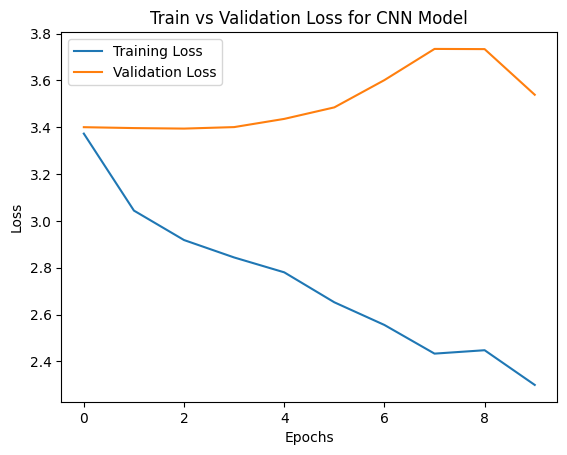

In [8]:
# Train vs Validation Loss for CNN Model
plt.plot(range(len(history.history["loss"])), history.history["loss"], label="Training Loss")
plt.plot(range(len(history.history["val_loss"])), history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss for CNN Model")
plt.legend()
plt.show()

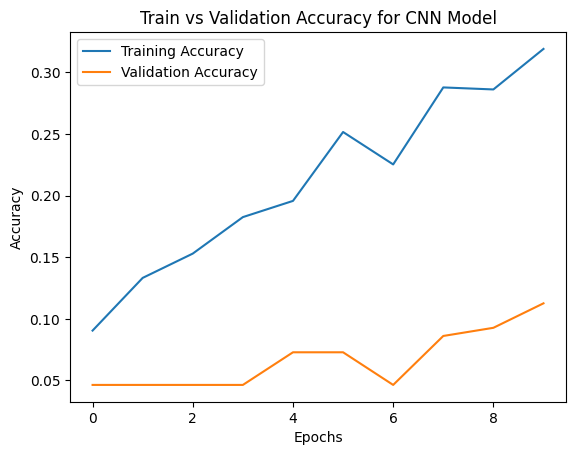

In [9]:
# Train vs Validation Accuracy for CNN Model
plt.plot(range(len(history.history["acc"])), history.history["acc"], label="Training Accuracy")
plt.plot(range(len(history.history["val_acc"])), history.history["val_acc"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuracy for CNN Model")
plt.legend()
plt.show()